# Exploratory Data Analysis- Insurance Data

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import math
from datetime import date
from statsmodels.stats.proportion import proportions_ztest

#### Variables

In [3]:
RARE_COUNT = 5
FEW_CATEGORIES = 10

## Load data

In [4]:
data_dict = pd.read_excel('claims_for_task.xlsx')
data = pd.read_excel('claims_for_task.xlsx', 1)

data_dict

,Field Name,Field Description,Type,Values
0,hashed_ph_id,policyholder id,String,NaN
1,hashed_claim_id,claim id,String,NaN
2,claim_start_date,claim start date,Date,NaN
3,claim_end_date,claim end (expiration) date,Date,NaN
4,GENDER,gender,Picklist,F / M
5,filing_state,state where the claim was filed,Picklist,NaN
6,claim_status,claim status,Picklist,Approved Closed / Denied / Approved-Reassessm...
7,eb_status,episode of beneift status,Picklist,Closed / Denied / Approved / Deceased / In Ass...
8,eb_reassessment_date,date of reassessment for episode of benefit,Date,NaN
9,primary_diagnosis,primary diagnosis,String,NaN


In [5]:
print(data.shape)
data.head(3)

(1170, 12)


,hashed_ph_id,hashed_claim_id,claim_start_date,claim_end_date,birth_date,GENDER,filing_state,claim_status,eb_status,eb_reassessment_date,primary_diagnosis,last_care_setting
0,1134,1362,30/12/2017,NaN,24/10/1929,M,MN,Denied,Denied,NaN,"Chronic kidney disease, unspecified",NaN
1,1255,1918,20/12/2016,24/12/2017,21/03/1933,F,FL,Approved Closed,Closed,NaN,Unspecified dementia,NH
2,1550,1286,24/07/2015,22/04/2017,1938-02-08 00:00:00,F,MO,Approved Closed,Closed,NaN,Unspecified dementia without behavioral distur...,NH


### Feature editing:

In [6]:
date_columns = ['claim_start_date', 'claim_end_date', 'eb_reassessment_date', 'birth_date']

for col in date_columns:
    data[col] = pd.to_datetime(data[col])

data['primary_diagnosis'] = data['primary_diagnosis'].str.lower()

## Data Exploration

In [7]:
print('The shape of the data:', str(data.shape[0]), 'rows and', str(data.shape[1]), 'columns')
print('number of unique claimants:', str(len(data.hashed_ph_id.unique())))
print('number of claims:', len(data.hashed_claim_id.unique()))


print('\nData description:')
df_des = data.describe(include = 'object').transpose()
df_des

The shape of the data: 1170 rows and 12 columns
number of unique claimants: 1000
number of claims: 1170

Data description:


,count,unique,top,freq
GENDER,1170,2,F,731
filing_state,1170,48,FL,115
claim_status,1170,5,Approved Closed,769
eb_status,1170,5,Closed,712
primary_diagnosis,1162,304,unspecified dementia without behavioral distur...,112
last_care_setting,842,6,NH,538


#### Define rare diagnosis

In [8]:
data['primary_aggregated_diagnosis'] = data['primary_diagnosis']
rare_category = (data['primary_diagnosis'].value_counts()[data['primary_diagnosis'].value_counts()\
                                                          < RARE_COUNT]).index

data.loc[data['primary_diagnosis'].isin(rare_category), 'primary_aggregated_diagnosis'] = 'other'
data.head(2)

,hashed_ph_id,hashed_claim_id,claim_start_date,claim_end_date,birth_date,GENDER,filing_state,claim_status,eb_status,eb_reassessment_date,primary_diagnosis,last_care_setting,primary_aggregated_diagnosis
0,1134,1362,2017-12-30,NaT,1929-10-24,M,MN,Denied,Denied,NaT,"chronic kidney disease, unspecified",NaN,"chronic kidney disease, unspecified"
1,1255,1918,2016-12-20,2017-12-24,1933-03-21,F,FL,Approved Closed,Closed,NaT,unspecified dementia,NH,unspecified dementia


#### Plot data

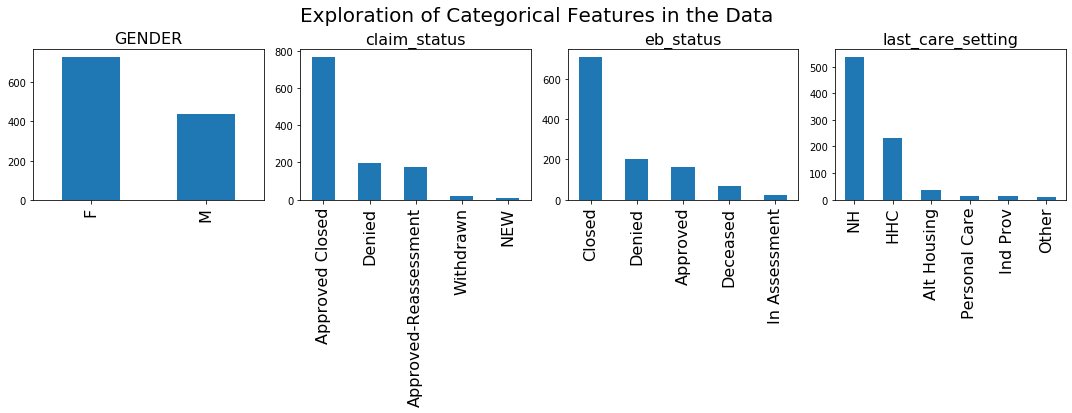

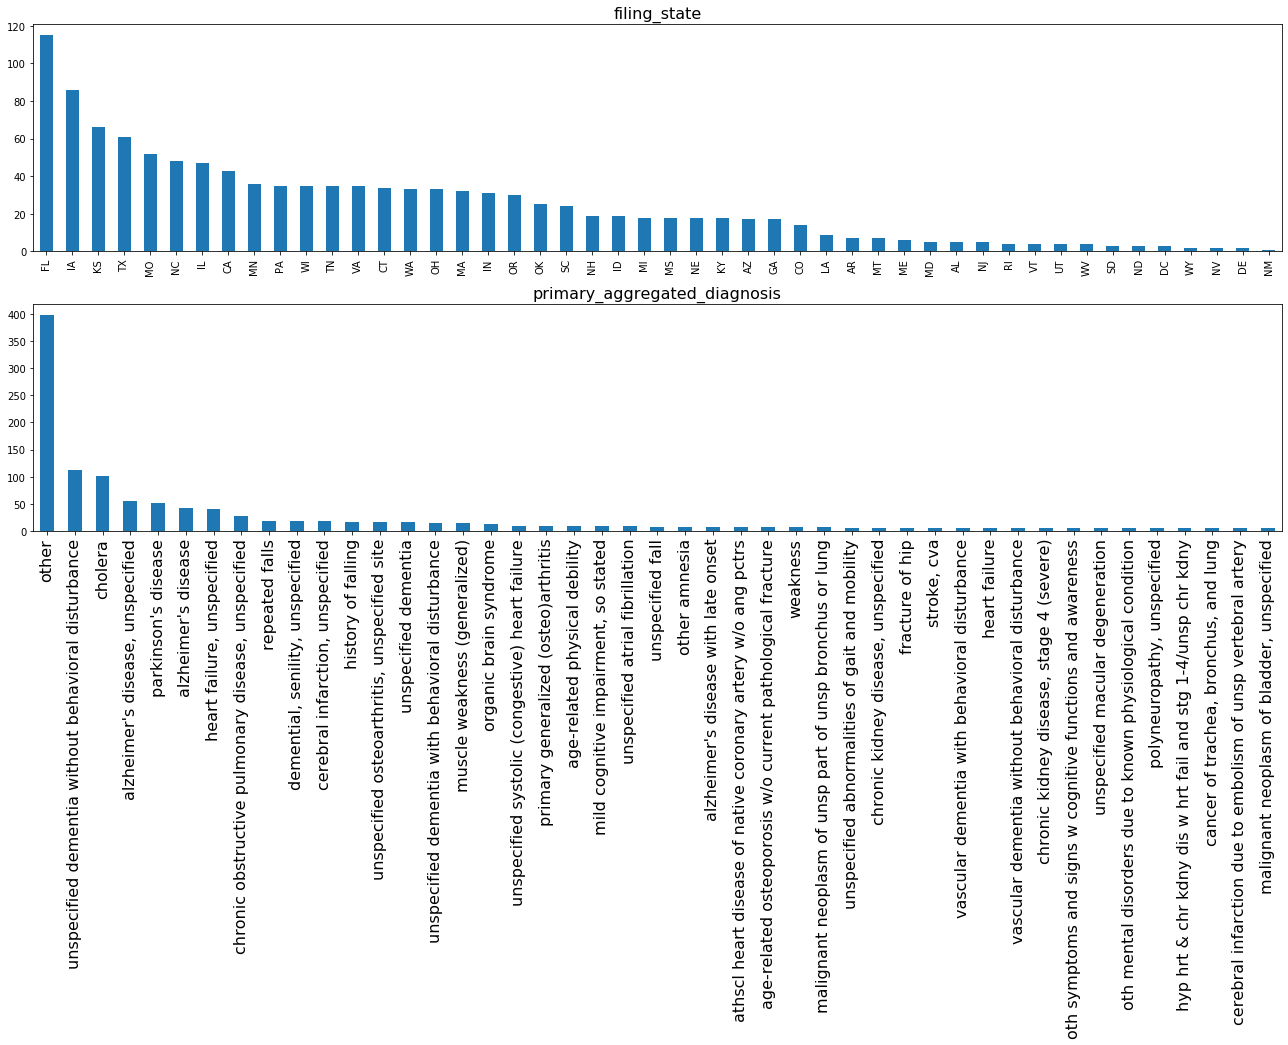

In [9]:
def plot_few_categories(data, few_categorical_features, fig):
    """Barplots for features with only few optional categories."""
    
    cnt = len(few_categorical_features)
    cols = len(few_categorical_features)
    rows = 1

    for i in range(cnt):
        feat = few_categorical_features[i]
        ax = fig.add_subplot(rows,cols,i+1)
        data[feat].value_counts().plot(kind="bar", ax=ax).set_title(feat, fontsize=16)
        plt.setp(ax.get_xticklabels(), Fontsize=16)
        plt.tight_layout()

    fig.subplots_adjust(top=0.85)

    fig = plt.figure(figsize=(18,12))
    
    return fig
    

def plot_many_categories(data, many_categorical_features, fig):
    """Barplots for features with many optional categories."""

    cols = 1
    rows = len(many_categorical_features)

    for i in range(rows):
        feat = many_categorical_features[i]
        
        ax = fig.add_subplot(rows,cols,i+1)
        data[feat].value_counts().plot(kind="bar", ax=ax).set_title(feat, fontsize=16)
        
    return ax


def plot_exploration(data):
    """Create data exploration plots."""
    
    few_categorical_features = df_des[df_des.unique < FEW_CATEGORIES].index
    many_categorical_features = ['filing_state', 'primary_aggregated_diagnosis']
    
    fig = plt.figure(figsize=(15,6))

    st = fig.suptitle("Exploration of Categorical Features in the Data", fontsize=20)
    st.set_y(0.95)
        
    fig = plot_few_categories(data, few_categorical_features, fig)
    ax = plot_many_categories(data, many_categorical_features, fig)
    
    plt.tight_layout()
    plt.setp(ax.get_xticklabels(), Fontsize=16)
    
    return
    
plot_exploration(data)

#### Explain missing values in the data:

1) Missing claim end date:

In [10]:
na_claim_end_date = data.loc[data.claim_end_date.isna(), :]
num_na_claim_date = na_claim_end_date.shape[0]

na_claim_end_date.describe(include = 'object').transpose()

,count,unique,top,freq
GENDER,226,2,F,130
filing_state,226,38,FL,23
claim_status,226,3,Denied,199
eb_status,226,4,Denied,199
primary_diagnosis,218,88,cholera,88
last_care_setting,0,0,NaN,NaN
primary_aggregated_diagnosis,218,33,cholera,88


In [11]:
print('There are', str(num_na_claim_date), 'claims with missing claim end date values.')
print('These represent ', str(round(num_na_claim_date / data.shape[0], 2)*100),\
      '% of the total number of claims.', sep='')


num_na_claim_end_date = na_claim_end_date[na_claim_end_date.claim_status.\
                                          isin(['NEW', 'Withdrawn', 'Denied'])].shape[0]

print('\n\nExplanations for the claims with missing end dates:\n')

print('1. The claim was denied. These account for ', \
      str(round((sum(na_claim_end_date.claim_status == 'Denied') / num_na_claim_date),2)*100) \
      , '% (', str(sum(na_claim_end_date.claim_status == 'Denied')), ') of the missing values', sep='')

print('2. The claim was withdrawn. These account for ', \
      str(round((sum(na_claim_end_date.claim_status == 'Withdrawn') / num_na_claim_date),2)*100) \
      , '% (', str(sum(na_claim_end_date.claim_status == 'Withdrawn')), ') of the missing values', sep='')

print('3. It\'s a new claim, that is still under assessment. These account for ', \
      str(round((sum(na_claim_end_date.claim_status == 'NEW') / num_na_claim_date),2)*100) \
      , '% (', str(sum(na_claim_end_date.claim_status == 'NEW')), ') of the missing values', sep='')

There are 226 claims with missing claim end date values.
These represent 19.0% of the total number of claims.


Explanations for the claims with missing end dates:

1. The claim was denied. These account for 88.0% (199) of the missing values
2. The claim was withdrawn. These account for 8.0% (18) of the missing values
3. It's a new claim, that is still under assessment. These account for 4.0% (9) of the missing values


2) Missing reassessment date:

In [12]:
na_eb_reassessment_date = data.loc[data.eb_reassessment_date.isna(), :]
num_na_eb_reassessment_date = na_eb_reassessment_date.shape[0]

print('There are', str(num_na_eb_reassessment_date), 'claims with missing reassessment date.')
print('These represent ', str(round(num_na_eb_reassessment_date / data.shape[0], 2)*100),\
      '% of the total number of claims.', sep='')

na_eb_reassessment_date.describe(include = 'object').transpose()

print('\nClaims with reassessment dates:')
has_eb_reassessment_date = data.loc[~(data.eb_reassessment_date.isna()), :]
has_eb_reassessment_date.describe(include = 'object').transpose()

There are 1019 claims with missing reassessment date.
These represent 87.0% of the total number of claims.

Claims with reassessment dates:


,count,unique,top,freq
GENDER,151,2,F,118
filing_state,151,36,IA,18
claim_status,151,2,Approved-Reassessment,150
eb_status,151,3,Approved,140
primary_diagnosis,151,81,unspecified dementia without behavioral distur...,22
last_care_setting,129,5,NH,66
primary_aggregated_diagnosis,151,29,other,57


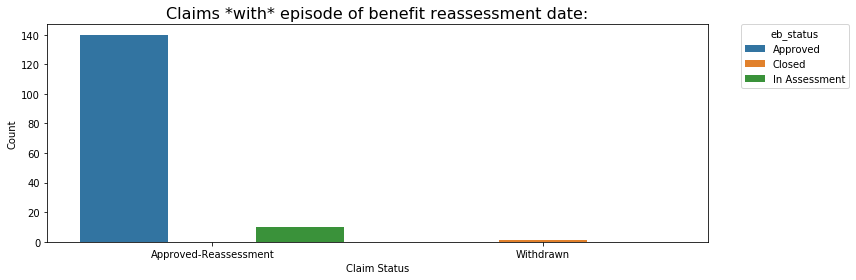

In [13]:
pv_date = has_eb_reassessment_date.pivot_table(index=['claim_status','eb_status'], aggfunc='size')
pv_date_unstack = pv_date.unstack().unstack().reset_index().fillna(0)
pv_date_unstack.columns = ['eb_status','claim_status','count']


fig = plt.figure(figsize=(12,4))

ax2 = sns.barplot(x='claim_status', y='count', hue='eb_status', data=pv_date_unstack)
ax2.set(xlabel='Claim Status', ylabel='Count')
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="eb_status")
ax2.set_title('Claims *with* episode of benefit reassessment date:', fontsize=16)
plt.tight_layout()

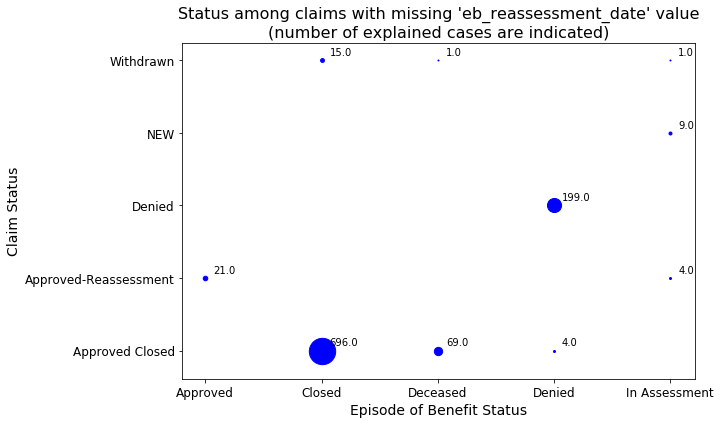

In [14]:
pv = na_eb_reassessment_date.pivot_table(index=['claim_status','eb_status'], aggfunc='size')
unstacked_pv = pv.unstack(level=-1).fillna(0)
unstacked_pv['level'] = [i for i in range(0, len(unstacked_pv))]

fig, ax = plt.subplots(figsize=(10,6))
for idx, eb_status in enumerate(unstacked_pv.columns[:-1]):
    df_gene = unstacked_pv[[eb_status, 'level']]    
    sList = [n for n in df_gene[eb_status]]
    for inr_idx, lv in enumerate(unstacked_pv['level']):
        ax.scatter(x=idx, y=lv, s=sList[inr_idx], c='blue')
        if sList[inr_idx] != 0:
            ax.annotate((sList[inr_idx]), (idx+0.07, lv+0.07))

fig.tight_layout()
plt.yticks([i for i in range(len(unstacked_pv.index))], list(unstacked_pv.index), fontsize=12)
plt.xticks([i for i in range(len(unstacked_pv.columns)-1)], list(unstacked_pv.columns[:-1]), fontsize=12)
plt.ylabel('Claim Status', fontsize=14)
plt.xlabel('Episode of Benefit Status', fontsize=14)
plt.title('Status among claims with missing \'eb_reassessment_date\' value\n\
(number of explained cases are indicated)', fontsize=16)
fig.tight_layout()
plt.show()


As we can see from the first figure above, reassessment dates generally appear for claims that had been approved or are under assessment at the moment. The exception is a single claim (id 1588), that was withdrawn, but still has a reassessment date (potentially by mistake).

From the other way around, in the second figure we can see that the majority of the claims with missing reassessment date are:
* Approved (or withdrawn) claims that had already been closed.
* Denied claims.
* Claims of deceased claimants.
* Claims that are currently under assessment: new claims, approved claims that passed their end date and a withdrawn claim, probably not yet updated in the data.
* 21 approved claims for reassessment: date wasn't scheduled yet(?)
* Lastly, 4 denied with 'Approved Closed' claim status which I'm not sure how to explain.

### First-time-approved claimants age distribution description

#### Define first approval dataset:

In [15]:
data_approved = data.loc[((data.claim_status == 'Approved Closed') | \
                      ((data.claim_status == 'Approved-Reassessment') & (data.eb_status == 'Approved')))]

first_approval = data_approved.sort_values('claim_start_date').groupby('hashed_ph_id', as_index=False).first()

#### Calculate age:

In [16]:
def calculate_age(row):
    """Calculates age of claimant based on birth date."""
    relative_date = row.claim_end_date
    return relative_date.year - row.birth_date.year - \
((relative_date.month, relative_date.day) < (row.birth_date.month, row.birth_date.day))

first_approval['age'] = first_approval.apply(calculate_age, axis=1)

The distribution of claimants ages upon first approved claims is left skewed, with a median age of 88.0 and with ages ranging from 55 to 101.

The distribution looks similar when segmented based on gender.


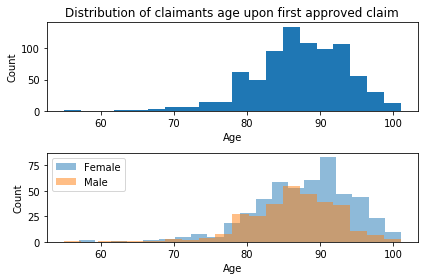

In [17]:
def plot_age_distribution(data):
    """Plots age distribution among all first time approved (all data or divided by gender)"""
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
    
    app_age_hist = ax1.hist(data['age'], bins=20)
    ax1.set_title('Distribution of claimants age upon first approved claim')
    ax1.set_ylabel('Count')
    ax1.set_xlabel('Age')


    x = data.loc[data.GENDER == 'F', 'age']
    y = data.loc[data.GENDER == 'M', 'age']
    bins = 20
    ax2.hist(x, bins, alpha=0.5, label='Female')
    ax2.hist(y, bins, alpha=0.5, label='Male')
    ax2.legend(loc='upper left')
    ax2.set_ylabel('Count')
    ax2.set_xlabel('Age')
    fig.tight_layout()
    
    return
    
plot_age_distribution(first_approval)

print('The distribution of claimants ages upon first approved claims is left skewed, with a median age of ',\
      str(first_approval['age'].median()),\
      ' and with ages ranging from ', \
      str(first_approval['age'].min()), \
      ' to ', str(first_approval['age'].max()), '.', sep='')
print('\nThe distribution looks similar when segmented based on gender.')

### First-time claimants gender distribution

#### Define first-time claimants:

In [18]:
first_time_claimants = data.iloc[data.groupby('hashed_ph_id', as_index=False).claim_start_date.idxmin()]

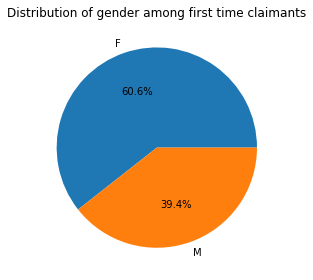

In [19]:
def plot_gender_distribution(data, title):
    """Plots gender distribution within an input dataframe."""
    
    fig, ax1 = plt.subplots()
    gender_pie_first_time = ax1.pie(data.GENDER.value_counts(),\
            labels = data.GENDER.value_counts().index, autopct='%1.1f%%')
    ax1.set_title(title)
    fig.tight_layout()
    
    return
    
plot_gender_distribution(first_time_claimants, 'Distribution of gender among first time claimants')

### Gender characterization of claimants who were ever denied a claim:

Male claimants have slightly higher prevalnce of ever being denied a claim. This difference is not significant.


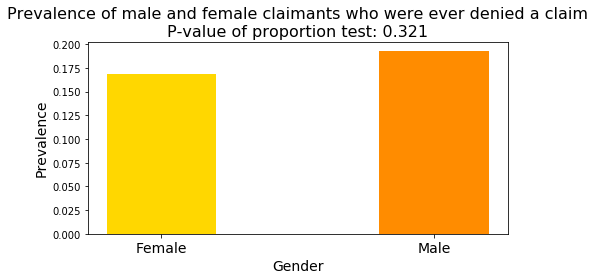

In [20]:
def characterize_denied(data):
    """Characterize the gender of claimants who were ever denied a claim."""

    female_claims = data[data.GENDER == 'F']
    male_claims = data[data.GENDER == 'M']

    num_female_claimants = len(female_claims.hashed_ph_id.unique())
    num_male_claimants = len(male_claims.hashed_ph_id.unique())

    num_female_claimants_denied = len(female_claims[female_claims.claim_status == 'Denied'].hashed_ph_id.unique())
    num_male_claimants_denied = len(male_claims[male_claims.claim_status == 'Denied'].hashed_ph_id.unique())

    counts = np.array([num_female_claimants_denied, num_male_claimants_denied])
    totals = np.array([num_female_claimants, num_male_claimants])
    stat, pval = proportions_ztest(counts, totals)

    pval_formatted = '{0:0.3f}'.format(pval)


    fig, ax1 = plt.subplots(figsize=(8,4))

    app_bar = ax1.bar(['F', 'M'], counts/totals, width=0.4, color=['gold', 'darkorange'])
    ax1.set_title('Prevalence of male and female claimants who were ever denied a claim\nP-value of \
proportion test: ' + str(pval_formatted), fontsize=16)
    ax1.set_xticklabels(['Female', 'Male'], fontsize=14)
    ax1.set_ylabel('Prevalence', fontsize=14)
    ax1.set_xlabel('Gender', fontsize=14)

    fig.tight_layout()
    
    return
    
characterize_denied(data)
print('Male claimants have slightly higher prevalnce of ever being denied a claim. This difference \
is not significant.')